In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

In [2]:
class PureQuine(nn.Module):
    def __init__(self, layer_sizes=[16,128,128,1]):
        super(PureQuine, self).__init__()
        self.orthogonal_layer = nn.Linear(layer_sizes[0], layer_sizes[0])
        nn.init.orthogonal_(self.orthogonal_layer.weight)
        nn.init.zeros_(self.orthogonal_layer.bias)
        self.layer_sizes = layer_sizes
        self.layers = nn.ModuleList([nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)])
        for layer in self.layers:
            nn.init.zeros_(layer.bias)
        max_binary_size = max(max(layer_sizes), len(layer_sizes)-1)
        binary_reps = []
        for i in range(max_binary_size):
            l = []
            x = i
            for _ in range(int(np.ceil(np.log2(max_binary_size)))):
                l.append((x % 2) * 2 - 1)
                x = x//2
            binary_reps.append(l)
        dataset = []
        for layer_number in range(len(layer_sizes)-1):
            for input_index in range(layer_sizes[layer_number]):
                for output_index in range(layer_sizes[layer_number+1]):
                    datapoint = binary_reps[layer_number][:int(np.ceil(np.log2(len(layer_sizes)-1)))] + binary_reps[input_index] + binary_reps[output_index]
                    dataset.append(datapoint)
        self.X = torch.FloatTensor(dataset)
    
    def forward(self, x):
        x = self.orthogonal_layer(x)
        for i in range(len(self.layers)-1):
            x = torch.nn.functional.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x
    
    def regenerate(self, shift = 1, contraction = 10000):
        out = self(self.X)/contraction + shift
        print(out)
        new_weights = out.split([self.layer_sizes[i]*self.layer_sizes[i+1] for i in range(len(self.layer_sizes)-1)])
        new_weights = [new_weights[i].view(self.layer_sizes[i+1], self.layer_sizes[i]).detach() for i in range(len(self.layer_sizes)-1)]
        for i in range(len(self.layers)):
            self.layers[i].weight = torch.nn.Parameter(new_weights[i])

In [3]:
layer_sizes = [22, 1024, 1024, 1024, 1]

In [840]:
network = PureQuine(layer_sizes = layer_sizes)

In [4]:
network = PureQuine(layer_sizes = layer_sizes)
for i in range(100):
    network_weights = torch.cat([layer.weight.view(-1) for layer in network.layers]).detach()
    network.regenerate(shift = 0.5, contraction=200000000)
    new_network_weights = torch.cat([layer.weight.view(-1) for layer in network.layers]).detach()
    loss = ((network_weights - new_network_weights)**2).mean()
    print(loss)
    print(((network_weights - new_network_weights)**2).mean()/(network_weights**2).mean())
    weight_dist = pd.Series(network_weights).value_counts()/len(network_weights)
    print(weight_dist)
    print(np.exp((-weight_dist*np.log(weight_dist)).sum()))

In [253]:
len(network_weights)

535040

In [188]:
pd.Series(network_weights).value_counts()

-0.069162    409017
-0.049222    126023
Name: count, dtype: int64

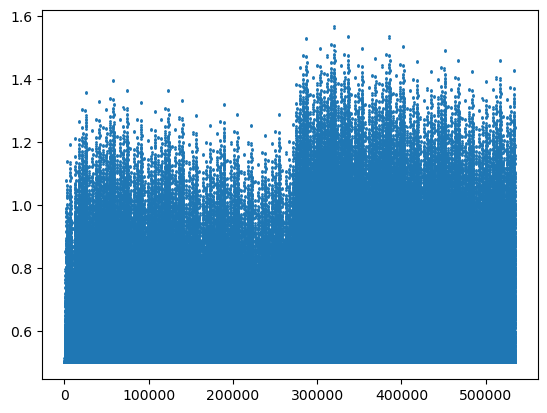

In [837]:
plt.scatter(range(len(network_weights)), network_weights,s=1)

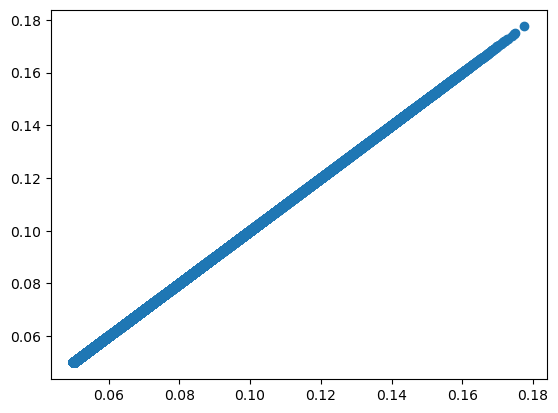

In [772]:
plt.scatter(network_weights, new_network_weights)

(array([3.40703e+05, 6.34180e+04, 5.10110e+04, 3.66670e+04, 2.30990e+04,
        1.24130e+04, 5.45200e+03, 1.82500e+03, 4.07000e+02, 4.50000e+01]),
 array([0.5       , 0.6067546 , 0.71350914, 0.82026374, 0.92701828,
        1.03377295, 1.14052749, 1.24728203, 1.35403657, 1.46079123,
        1.56754577]),
 <BarContainer object of 10 artists>)

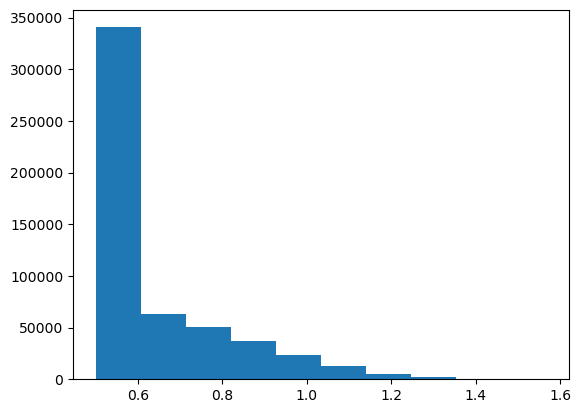

In [838]:
plt.hist(network_weights)

In [64]:
print(new_network_weights.mean())
print(new_network_weights.std())
print(new_network_weights.min())

tensor(-0.0502)
tensor(0.0001)
tensor(-0.0503)


In [14]:
times = []
for i in range(3,11):
    layer_sizes = [2 + 2*i, 2**i, 2**i, 2**i, 1]
    network = PureQuine(layer_sizes = layer_sizes)
    start = datetime.datetime.now()
    network.regenerate(shift = -0.05)
    times.append(datetime.datetime.now()-start)
    print(i)
    print(times[-1])

tensor([[0.0610],
        [0.0570],
        [0.0600],
        [0.0576],
        [0.0680],
        [0.0648],
        [0.0657],
        [0.0643],
        [0.0659],
        [0.0617],
        [0.0612],
        [0.0590],
        [0.0703],
        [0.0696],
        [0.0650],
        [0.0640],
        [0.0558],
        [0.0518],
        [0.0587],
        [0.0553],
        [0.0629],
        [0.0596],
        [0.0653],
        [0.0611],
        [0.0616],
        [0.0573],
        [0.0632],
        [0.0596],
        [0.0680],
        [0.0652],
        [0.0658],
        [0.0651],
        [0.0649],
        [0.0609],
        [0.0658],
        [0.0620],
        [0.0672],
        [0.0648],
        [0.0672],
        [0.0644],
        [0.0690],
        [0.0642],
        [0.0664],
        [0.0621],
        [0.0717],
        [0.0700],
        [0.0674],
        [0.0674],
        [0.0605],
        [0.0557],
        [0.0617],
        [0.0572],
        [0.0620],
        [0.0591],
        [0.0625],
        [0

Text(0, 0.5, 'Regeneration Step Seconds')

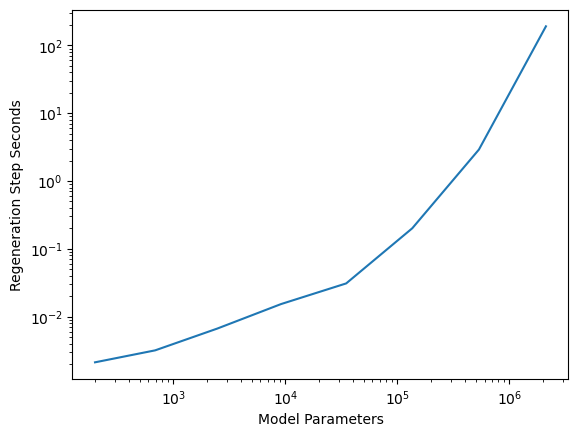

In [23]:
plt.plot([(2 + 2*i) * 2**i + 2*2**i*2**i + 2**i for i in range(3,11)],[t.total_seconds() for t in times])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Model Parameters")
plt.ylabel("Regeneration Step Seconds")

In [5]:
int(np.log2(1024))

10

In [6]:
network.regenerate(shift = -0.05)

tensor([[0.0467],
        [0.0501],
        [0.0489],
        ...,
        [0.0486],
        [0.0485],
        [0.0493]], grad_fn=<SubBackward0>)


In [7]:
network_weights = torch.cat([layer.weight.view(-1) for layer in network.layers]).detach()
network_predictions = network(network.X)
mse = ((network_weights - network_predictions)**2).mean()
print(network_weights.var())
print(mse)

: 

In [29]:
network.regenerate(shift = -0.05)
plt.scatter(torch.cat([layer.weight.view(-1) for layer in network.layers]).detach(), (network(network.X)/10000 + .05).view(-1).detach())

tensor([[0.0500],
        [0.0500],
        [0.0500],
        ...,
        [0.0500],
        [0.0500],
        [0.0500]], grad_fn=<SubBackward0>)
tensor([[0.0500],
        [0.0500],
        [0.0500],
        ...,
        [0.0501],
        [0.0501],
        [0.0502]], grad_fn=<SubBackward0>)
tensor([[0.0500],
        [0.0500],
        [0.0500],
        ...,
        [0.0501],
        [0.0501],
        [0.0502]], grad_fn=<SubBackward0>)
tensor([[0.0500],
        [0.0500],
        [0.0500],
        ...,
        [0.0501],
        [0.0501],
        [0.0502]], grad_fn=<SubBackward0>)
tensor([[0.0500],
        [0.0500],
        [0.0500],
        ...,
        [0.0501],
        [0.0501],
        [0.0502]], grad_fn=<SubBackward0>)
tensor([[0.0500],
        [0.0500],
        [0.0500],
        ...,
        [0.0501],
        [0.0501],
        [0.0502]], grad_fn=<SubBackward0>)
tensor([[0.0500],
        [0.0500],
        [0.0500],
        ...,
        [0.0501],
        [0.0501],
        [0.0502]], gr

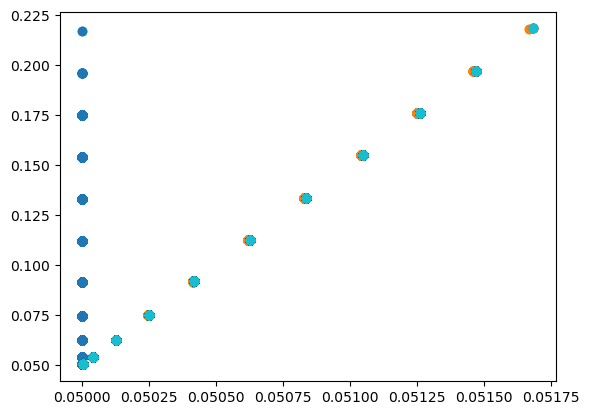

In [ ]:
network = PureQuine(layer_sizes = layer_sizes)
for i in range(10):
    network.regenerate(shift = -0.05)
    plt.scatter(torch.cat([layer.weight.view(-1) for layer in network.layers]).detach(), (network(network.X)/10000 + .05).detach())

In [ ]:
network(network.X).view(-1)/10000 + .05

tensor([0.0502, 0.0502, 0.0502,  ..., 0.0626, 0.0626, 0.0749],
       grad_fn=<AddBackward0>)

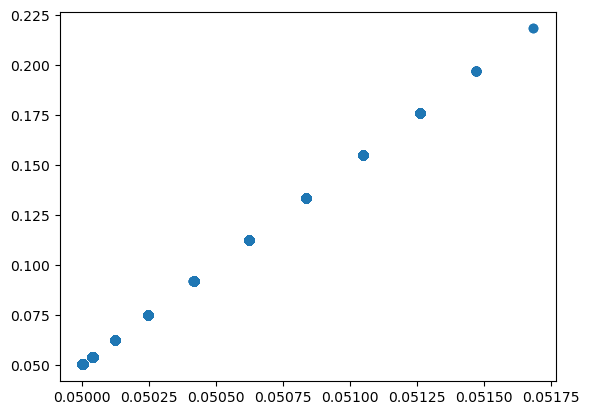

In [ ]:
plt.scatter(torch.cat([layer.weight.view(-1) for layer in network.layers]).detach(), (network(network.X)/10000 + .05).view(-1).detach())

In [ ]:
max_binary_size = max(max(layer_sizes), len(layer_sizes)-1)

In [ ]:
np.ceil(np.log2(len(layer_sizes)-1))

2.0

In [ ]:
max_binary_size

256

In [ ]:
binary_reps = []
for i in range(max_binary_size):
    l = []
    x = i
    for _ in range(int(np.ceil(np.log2(max_binary_size)))):
        l.append(x % 2)
        x = x//2
    binary_reps.append(l)

In [ ]:
dataset = []
for layer_number in range(len(layer_sizes)-1):
    for input_index in range(layer_sizes[layer_number]):
        for output_index in range(layer_sizes[layer_number+1]):
            datapoint = binary_reps[layer_number][:int(np.ceil(np.log2(len(layer_sizes)-1)))] + binary_reps[input_index] + binary_reps[output_index]
            dataset.append(datapoint)
X = torch.FloatTensor(dataset)
X[-1]
    

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
layer_shapes = [layer.weight.shape for layer in network.layers]

In [ ]:
out = network(X)

In [ ]:
new_weights = out.split([layer_sizes[i]*layer_sizes[i+1] for i in range(len(layer_sizes)-1)])
new_weights = [new_weights[i].view(layer_sizes[i], layer_sizes[i+1]).detach() for i in range(len(layer_sizes)-1)]

In [ ]:
for i in range(len(network.layers)):
    network.layers[i].weight = torch.nn.Parameter(new_weights[i])

In [ ]:
layer_shapes[0]

torch.Size([256, 18])